<a href="https://colab.research.google.com/github/shayar/DM-Final-Project/blob/main/MJC_SS_Data_Mining_Final_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Data Mining Final Project

by

Matthew Curran and

Shayar Shrestha

# Load Data and Imports

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = 'http://pluto.hood.edu/~dong/datasets/osa_hf.csv'
data = pd.read_csv(url, header='infer')
data.head(1)

,bmi,hospital_expire_flag,los,age,charlson,"Calculated Bicarbonate, Whole Blood",Calculated Total CO2,"Chloride, Whole Blood",Free Calcium,Glucose,...,insurance_Medicare,insurance_Other,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,admission_type_ELECTIVE,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT
0,0.21743,0,0.902069,0.611765,0.45,0.0,0.068493,0.090909,0.564516,0.103448,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# EDA

Dataset Overview
Shape: (10841, 764)
Column Data Types:
float64    763
int64        1
Name: count, dtype: int64
No missing values found.

Unique Values in Each Column:
Hepatitis A Virus IgM Antibody                             1
Lymphocytes.2                                              1
Salicylate                                                 1
Benzodiazepine Screen                                      1
Rheumatic disorders of both mitral and aortic valves       2
                                                        ... 
Creatinine                                                49
Glucose.1                                                 52
age                                                       82
bmi                                                      856
los                                                     7502
Length: 764, dtype: int64

Constant Features (No Variance): ['Benzodiazepine Screen', 'Hepatitis A Virus IgM Antibody', 'Salicylate', 'Lymphocytes.2']

Summary S

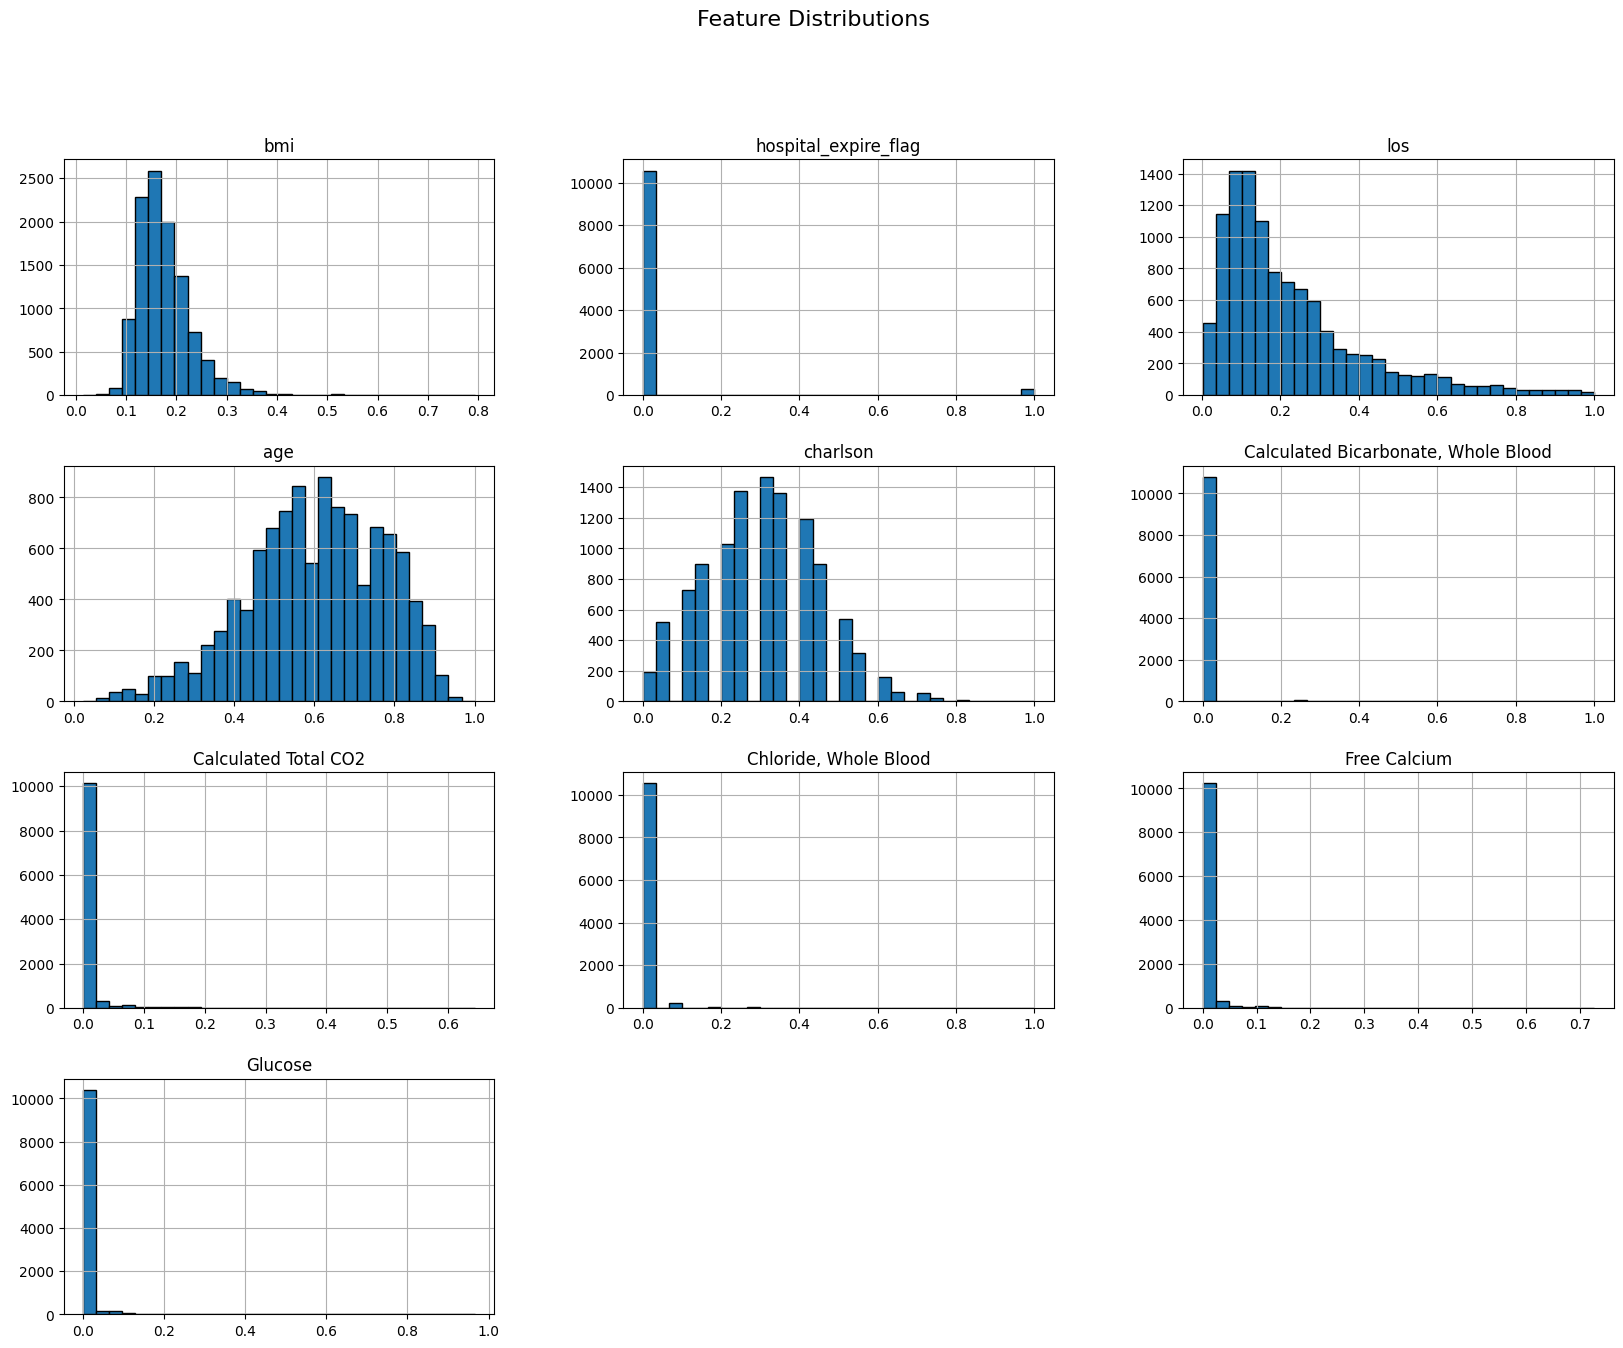


Correlation Matrix:


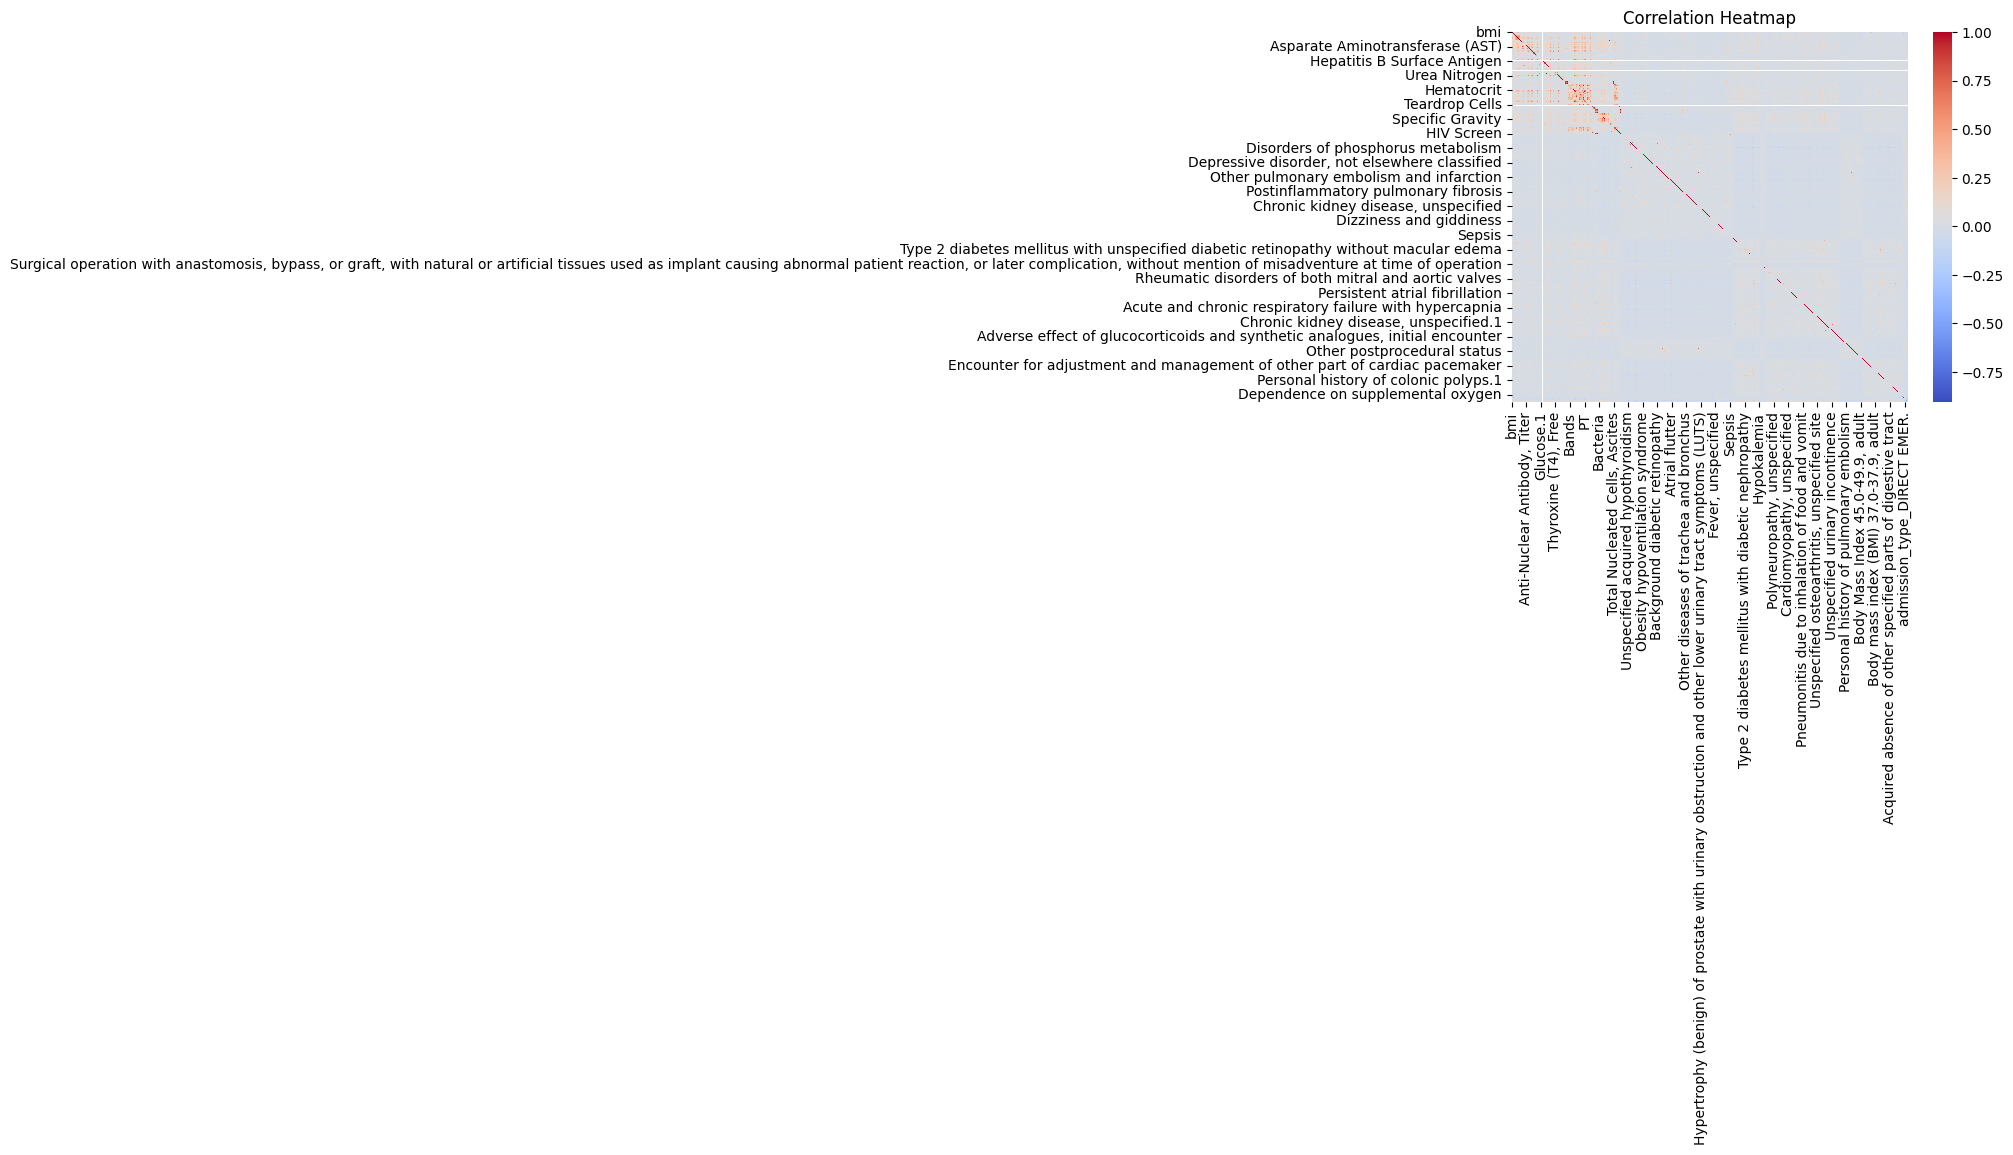


Highly Correlated Feature Pairs (Correlation > 0.85):
INR(PT)                                                                                                           PT                                 0.998946
Iron Binding Capacity, Total                                                                                      Transferrin                        0.995909
Lymphocytes                                                                                                       Total Nucleated Cells, Ascites     0.993811
RBC, Ascites                                                                                                      Total Nucleated Cells, Ascites     0.990722
Lymphocytes.4                                                                                                     Total Nucleated Cells, Pleural     0.988424
Polys                                                                                                             Total Nucleated Cells, Ascites     0.9876

In [24]:
print("Dataset Overview")
print(f"Shape: {data.shape}")
print("Column Data Types:")
print(data.dtypes.value_counts())

# Check for missing values
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]
if not missing_values.empty:
    print("Missing Values Count:")
    print(missing_values)
else:
    print("No missing values found.")

# Checking unique values
print("\nUnique Values in Each Column:")
print(data.nunique().sort_values())

# Identifying features with only one unique value, as they provide no useful information
constant_features = [col for col in data.columns if data[col].nunique() == 1]
print("\nConstant Features (No Variance):", constant_features)

# Summary statistics
print("\nSummary Statistics:")
print(data.describe().T)

# Visualize the distribution of a random sample of columns (for the first 10 columns)
print("\nVisualizing feature distributions...")
data.iloc[:, :10].hist(figsize=(20, 15), bins=30, layout=(4, 3), edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()

# Correlational Analysis
print("\nCorrelation Matrix:")
corr_matrix = data.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Checking highly correlated features (correlations above 0.85)
high_corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = high_corr_pairs.stack().sort_values(ascending=False)
print("\nHighly Correlated Feature Pairs (Correlation > 0.85):")
print(high_corr_pairs[high_corr_pairs > 0.85])

# Outlier Detection
outlier_counts = {}
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))).sum()
    if outliers > 0:
        outlier_counts[col] = outliers
print("\nOutliers Detected:")
print(outlier_counts)

# EDA Conclusion:

*  There were no any missing values found in any column along with the features having valid data.
*    While checking the uniqueness of the features, these 4  feature i.e (Benzodiazepine Screen', 'Hepatitis A Virus IgM Antibody', 'Salicylate', 'Lymphocytes.2) didn't have any variance.
* Checking the correlation between the features, we got to see that only few of them were highly correlated while most of the features didn't have good correlations.
* From the summary statistics, we didn't learn anything.
* From the feature visualization, we can see that most of the feature are normal distribution. Given, the large amount of feature, it is impossible to look for each feature. We didn't see anything unusual.
* While detecting the outliers, we found alot of the features had outliers. Since, we lack SME (subject matter expertise) in this topic, we couldn't determine which outlier might represent bad data.

Final Conclusion from EDA:

* Although, there are alot of features and its a large dataset, we can see that all of them have good data.

# Data Preprocessing

In [25]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# K-Means Helper Function

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def kMeansHelper(data):
  # Determine optimal number of clusters using the elbow method
  inertia = []
  sil_scores = []
  range_clusters = range(2, 10)

  for k in range_clusters:
      kmeans = KMeans(n_clusters=k, random_state=42)
      kmeans.fit(data)
      inertia.append(kmeans.inertia_)
      sil_scores.append(silhouette_score(data, kmeans.labels_))

  # Elbow method plot
  plt.figure(figsize=(8, 5))
  plt.plot(range_clusters, inertia, marker='o')
  plt.title('Elbow Method for Optimal K')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Inertia')
  plt.show()

  # Silhouette scores plot
  plt.figure(figsize=(8, 5))
  plt.plot(range_clusters, sil_scores, marker='o', color='orange')
  plt.title('Silhouette Scores for Different K')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Silhouette Score')
  plt.show()

  return sil_scores

# K-Means before Dimension Reduction

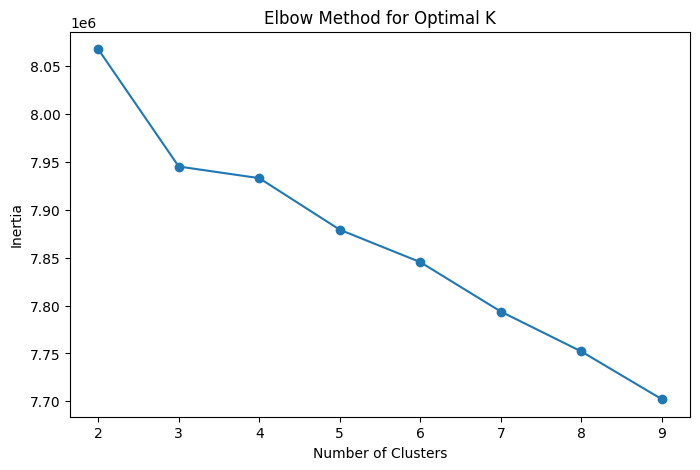

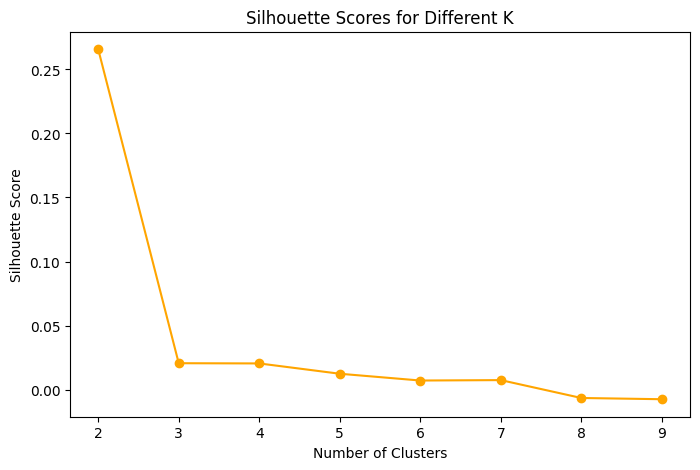

In [27]:
sil_scores = kMeansHelper(scaled_data)

# Apply K-Means with optimal clusters
  # optimal_k = 5  # Example based on silhouette/elbow
  # kmeans = KMeans(n_clusters=optimal_k, random_state=42)
  # kmeans_labels = kmeans.fit_predict(data)

Looking at the elbow curves, we can see that the optimal k value is between 3 and 7.

In [28]:
# Printing the sil scores
for i in range(3,8):
  print(f"Silhouette Score for k={i}: {sil_scores[i]:.3f}")


Silhouette Score for k=3: 0.012
Silhouette Score for k=4: 0.007
Silhouette Score for k=5: 0.007
Silhouette Score for k=6: -0.007
Silhouette Score for k=7: -0.008


PCA reduced the dataset to 260 dimensions.


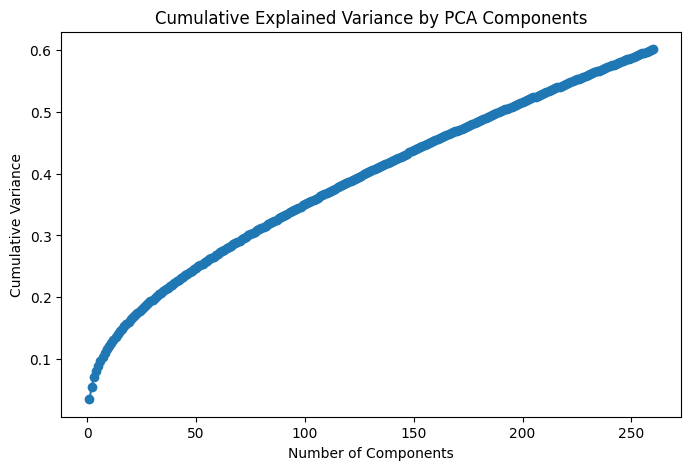

t-SNE transformation completed.


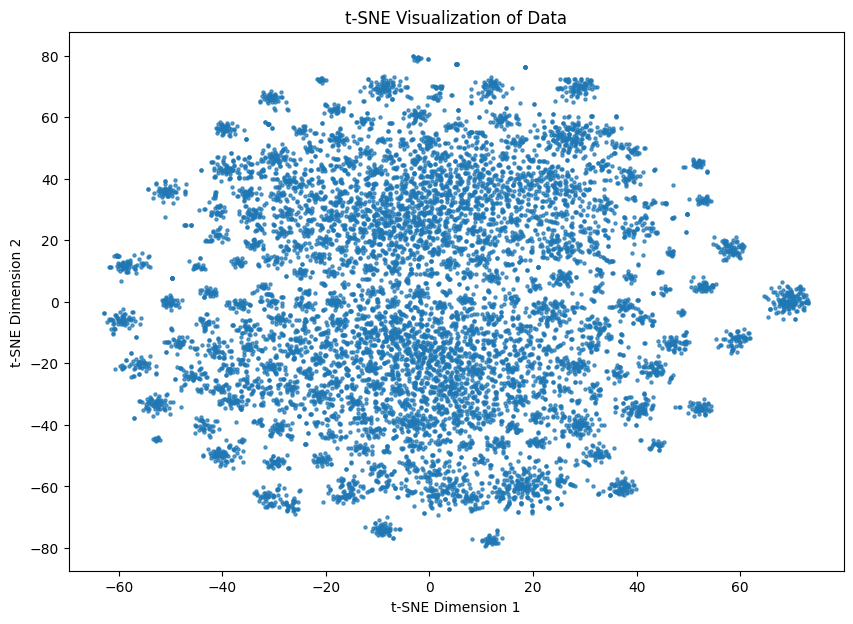

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.6)  # Retain 60% variance
pca_data = pca.fit_transform(scaled_data)
print(f"PCA reduced the dataset to {pca_data.shape[1]} dimensions.")

# Visualize variance explained by components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.show()

# Optionally apply t-SNE for further dimensionality reduction (2D visualization)
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(pca_data)
print("t-SNE transformation completed.")

# Visualize t-SNE
plt.figure(figsize=(10, 7))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=5, alpha=0.7)
plt.title('t-SNE Visualization of Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


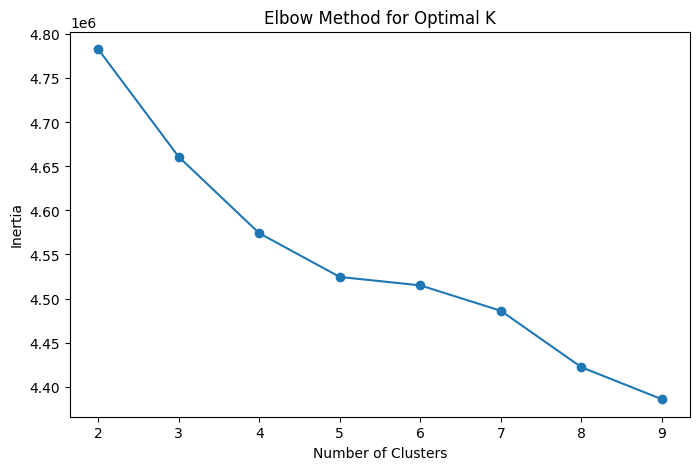

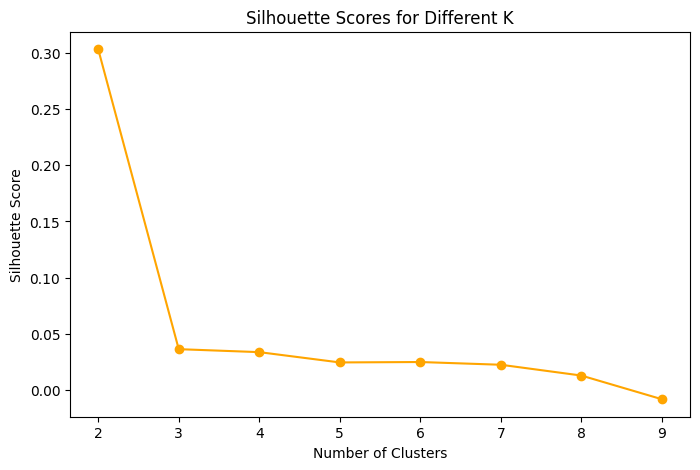

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine optimal number of clusters using the elbow method
inertia = []
sil_scores = []
range_clusters = range(2, 10)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(pca_data, kmeans.labels_))

# Elbow method plot
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Silhouette scores plot
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, sil_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Apply K-Means with optimal clusters
optimal_k = 4  # Example based on silhouette/elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_data)


# Hierachical Clustering

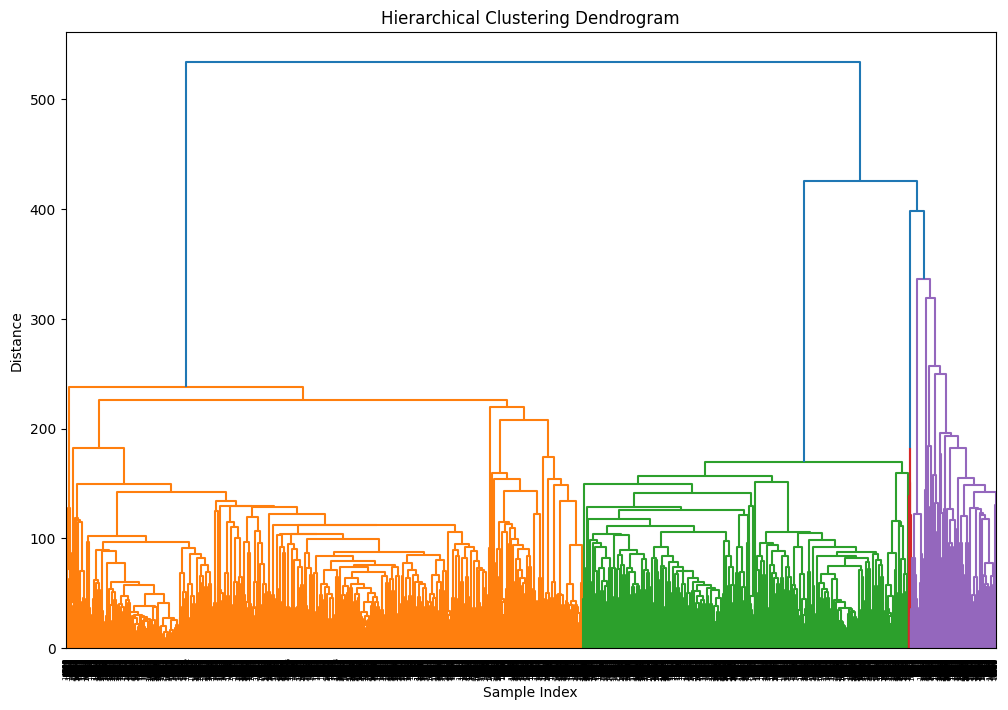

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Generate linkage matrix
linkage_matrix = linkage(pca_data, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Apply Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=optimal_k)
agg_labels = agg_cluster.fit_predict(pca_data)


# Evaluating the score

In [11]:
from sklearn.metrics import davies_bouldin_score

# Evaluate K-Means Clustering
sil_kmeans = silhouette_score(pca_data, kmeans_labels)
db_kmeans = davies_bouldin_score(pca_data, kmeans_labels)

# Evaluate Agglomerative Clustering
sil_agg = silhouette_score(pca_data, agg_labels)
db_agg = davies_bouldin_score(pca_data, agg_labels)

print(f"K-Means Silhouette Score: {sil_kmeans}, Davies-Bouldin Index: {db_kmeans}")
print(f"Agglomerative Clustering Silhouette Score: {sil_agg}, Davies-Bouldin Index: {db_agg}")


K-Means Silhouette Score: 0.033678278470562845, Davies-Bouldin Index: 3.8792305696987848
Agglomerative Clustering Silhouette Score: 0.02288423230457795, Davies-Bouldin Index: 4.08651622001664


# Interpreting and analysis

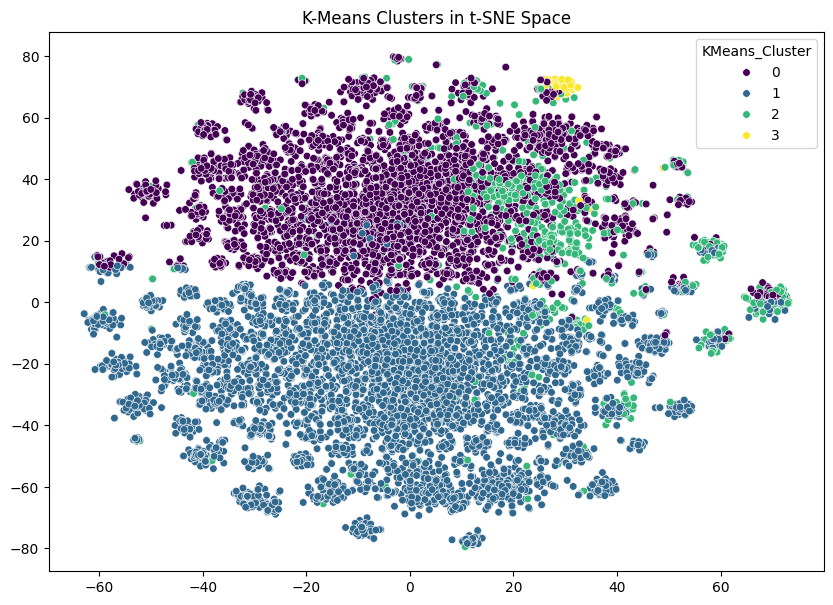

Cluster Characteristics:
                     bmi  hospital_expire_flag       los       age  charlson  \
KMeans_Cluster                                                                 
0               0.178719              0.009865  0.204191  0.606550  0.301372   
1               0.174057              0.015069  0.189000  0.601520  0.288055   
2               0.169946              0.163912  0.580794  0.609447  0.364532   
3               0.168802              0.188679  0.527050  0.655494  0.377358   

                Calculated Bicarbonate, Whole Blood  Calculated Total CO2  \
KMeans_Cluster                                                              
0                                          0.001023              0.002360   
1                                          0.000804              0.003101   
2                                          0.008264              0.052360   
3                                          0.000000              0.010339   

                Chloride, Whole

In [12]:
# Add labels to the dataset
data['KMeans_Cluster'] = kmeans_labels
data['Agglomerative_Cluster'] = agg_labels

# Visualize clusters in t-SNE space
plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=data['KMeans_Cluster'], palette='viridis', s=30)
plt.title('K-Means Clusters in t-SNE Space')
plt.show()

# Cluster characteristics
cluster_summary = data.groupby('KMeans_Cluster').mean()
print("Cluster Characteristics:")
print(cluster_summary)


# References

# Print All

In [13]:
# PRINT TO PDF
# do not include the output from installation.
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!pip install nbconvert

# Clear output:
from IPython.display import clear_output
clear_output()

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!jupyter nbconvert '/content/drive/MyDrive/Colab Notebooks/MJC_SS_Data_Mining_Final_Part_2.ipynb' --to pdf

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/MJC_SS_Data_Mining_Final_Part_2.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    